## Assignment 2 - Clustering

## Learning Outcomes

In this assignment, you will do the following:

* Explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset



## Problem Description

In this assignment, you will study the electricity demand from clients in Portugal, during 2013 and 2014. You have been provided with the data file, which you should download when you download this assignment file.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise, you will use clustering techniques to understand the typical usage behaviour during 2013-2014.

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

We will start by exploring the data set and continue on to the assignment.  Consider this as a working notebook, you will add your work to the same notebook.

In this assignment we will use the sklearn package for k-means.  Please refer here for the documentation https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

The sklearn package for k-means is one of the many clustering algorithms found in the module "sklearn.cluster".  These come with a variety of functions that you can call by importing the package.

For example 
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import KMeans



## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [3]:
pathToFile = r"./assignment2-data/"
#pathToFile = r"C:\\Users\\<your username>\\Downloads\\"

fileName = 'LD2011_2014.txt'

In [30]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
random.seed(42)

In [4]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [5]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [6]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [8]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [10]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the first 2 days of 2012 for the first 2 clients

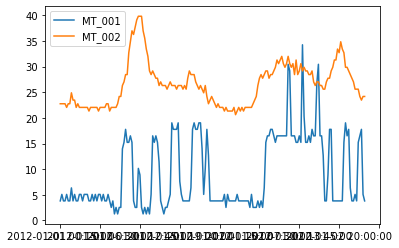

In [11]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [12]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [13]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [14]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [15]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [16]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data['hour'] = data.index.map(lambda x: x[11:])

In [19]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [20]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [22]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

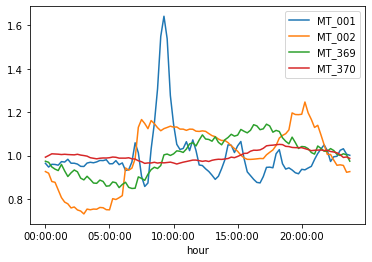

In [23]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [29]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format

# Questions (15 marks total)

**Q1: (7 marks)**

a. Determine what a convenient number of clusters. Justify your choice.  Make use of the sklearn's package for k-means for this. You may refer to the module to figure out how to come up with the optimal number of clusters. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".
    
You have 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [105]:
# Determine what a convenient number of clusters.
n_clusters= np.arange(2,15)   # Hyperparameters to evaluate

In [106]:
inertias = []
silhouette = []
for k in n_clusters:
    kmm = KMeans(n_clusters=k)
    kmm.fit(X)
    labels = kmm.labels_
    inertias.append(kmm.inertia_)
    silhouette.append(silhouette_score(X, labels))


I'll use an elbow graph to choose the number of clusters (k) that is optimal. But I'll include the Silhouette Score to the analysis.

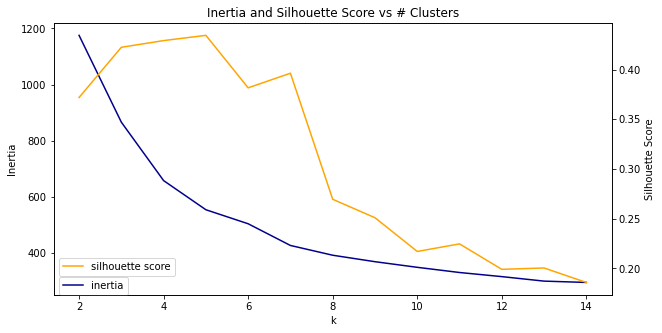

In [113]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(n_clusters, inertias, c="darkblue", label="inertia")
ax2.plot(n_clusters, silhouette, c="orange", label="silhouette score")
plt.title("Inertia and Silhouette Score vs # Clusters")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia")
ax2.set_ylabel("Silhouette Score")
ax1.legend(loc=(0.01,0))
ax2.legend(loc=(0.01,0.07))
plt.show()

After $k=4$ the inertia starts decreasing at a lower rate. On the other side, the higher Silhouette Score is at 5. From that, taking 5 clusters seems to be the best option. Now, I will train the model for $k=5$.

In [108]:
kmm = KMeans(n_clusters=5)
best_kmm = kmm.fit(X)

In [109]:
best_kmm.inertia_

553.8272084963307

In [148]:
# Number of clients in the cluster
labels = best_kmm.labels_
cols_names = average_curves_norm.index.tolist()
cols_names.append("labels")
X_labeled = pd.DataFrame(np.append(X, labels.reshape((349,1)), axis=1), columns=cols_names)

In [204]:
number_of_clients = X_labeled.groupby('labels').size()
mean_by_cluster = X_labeled.groupby('labels').mean()

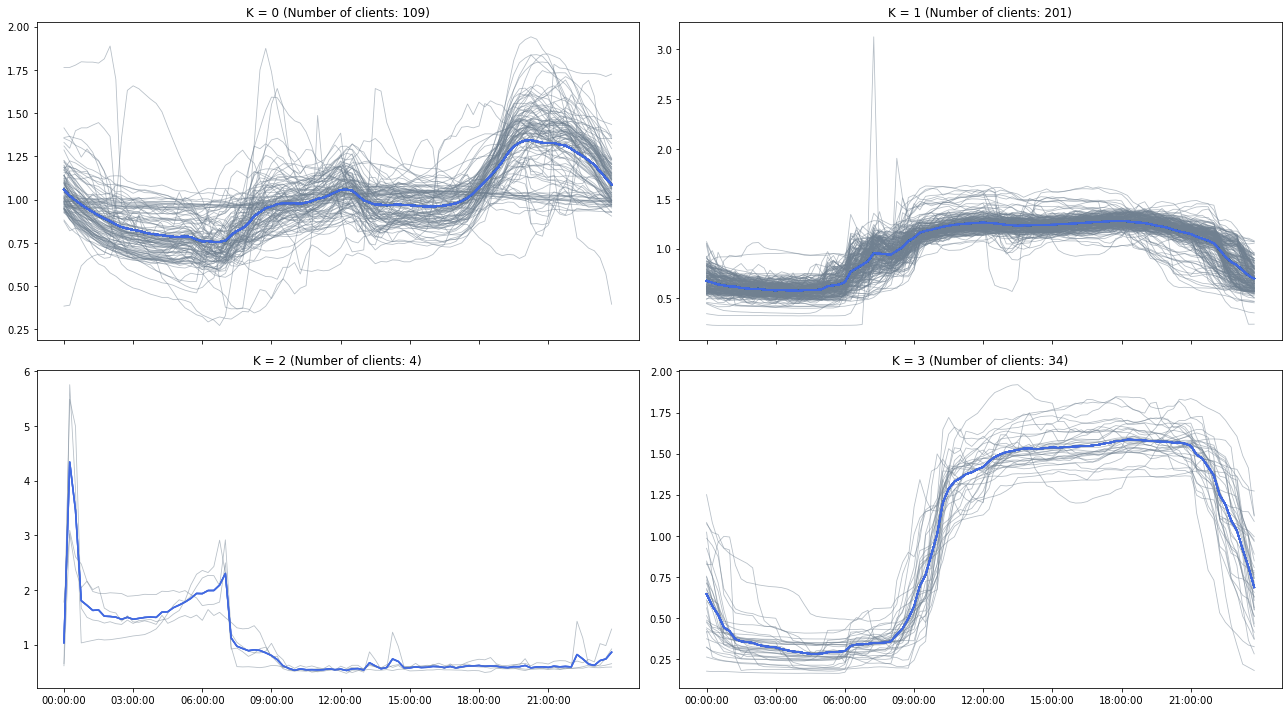

In [219]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,10), sharex=True)

for index, row in X_labeled.iterrows():
    if row['labels'] == 0:
        axs[0,0].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[0,0].plot(mean_by_cluster.iloc[0,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[0,0].set_title("K = 0 (Number of clients: {})".format(number_of_clients[0]))
    elif row['labels'] == 1:
        axs[0,1].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[0,1].plot(mean_by_cluster.iloc[1,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[0,1].set_title("K = 1 (Number of clients: {})".format(number_of_clients[1]))
    elif row['labels'] == 2:
        axs[1,0].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[1,0].plot(mean_by_cluster.iloc[2,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[1,0].set_title("K = 2 (Number of clients: {})".format(number_of_clients[2]))
    elif row['labels'] == 3:
        axs[1,1].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[1,1].plot(mean_by_cluster.iloc[3,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[1,1].set_title("K = 3 (Number of clients: {})".format(number_of_clients[3]))

plt.xticks(X_labeled.columns[:-1:12])
plt.tight_layout()
plt.show()

From the information shown in the plots, a possible way of categorizing each cluster would be:
* $k=0$ Domestic use, people get up around 7 am, and get back from work at 7pm, that is when the consumption increase the most.
* $k=1$ Offices, as the consumption increases at labor hours (9am to 6 pm).
* $k=3$ Factories, similar to offices but the increase is higher.
* $k=2$ Places when consuption is higher at night, although there are little cases in this cluster.

**Q2: (8 marks)**

In this exercise you work with the daily curves of 1 single client.
First, create a list of arrays, each array containing a curve for a day. You may use X from the cells above.
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters? 

b. Based on your results from your analyses of both methods, what do understand?  Interpret it perhaps with different perspectives of timelines like weeks or months.

In [221]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])])

In [222]:
len(X)

730

In [223]:
# Determine what a convenient number of clusters.
n_clusters= np.arange(2,15)   # Hyperparameters to evaluate

In [224]:
inertias = []
silhouette = []
for k in n_clusters:
    kmm = KMeans(n_clusters=k)
    kmm.fit(X)
    labels = kmm.labels_
    inertias.append(kmm.inertia_)
    silhouette.append(silhouette_score(X, labels))


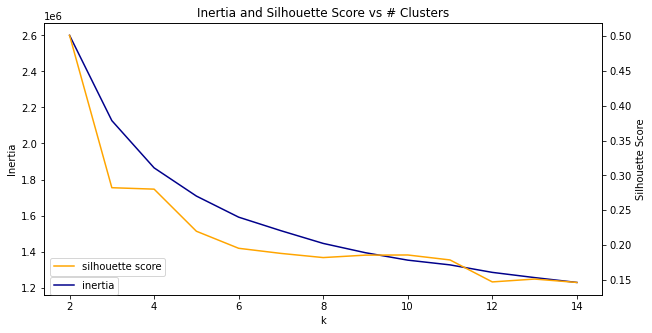

In [225]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(n_clusters, inertias, c="darkblue", label="inertia")
ax2.plot(n_clusters, silhouette, c="orange", label="silhouette score")
plt.title("Inertia and Silhouette Score vs # Clusters")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia")
ax2.set_ylabel("Silhouette Score")
ax1.legend(loc=(0.01,0))
ax2.legend(loc=(0.01,0.07))
plt.show()

In this case, the greaterst Silhouette Score is at $k=2$, although the inertia has an important decrease at $k=3$, it make sense to keep $k=2$.

In [226]:
kmm = KMeans(n_clusters=2)
best_kmm = kmm.fit(X)

In [235]:
# Number of clients in the cluster
labels = best_kmm.labels_
X_labeled = pd.DataFrame(np.append(X, labels.reshape((730,1)), axis=1), columns=cols_names)

In [236]:
number_of_clients = X_labeled.groupby('labels').size()
mean_by_cluster = X_labeled.groupby('labels').mean()

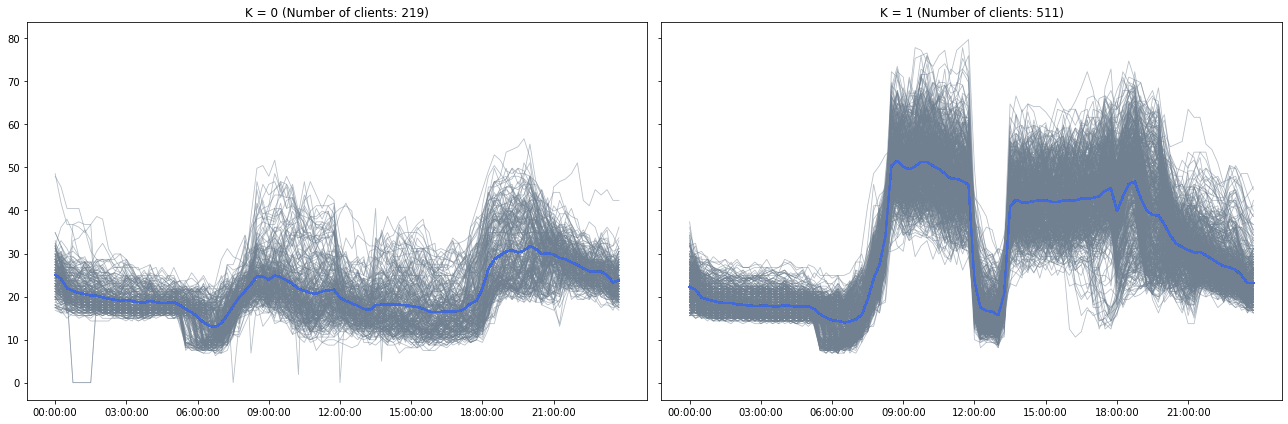

In [241]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True)

for index, row in X_labeled.iterrows():
    if row['labels'] == 0:
        axs[0].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[0].plot(mean_by_cluster.iloc[0,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[0].set_title("K = 0 (Number of clients: {})".format(number_of_clients[0]))
    elif row['labels'] == 1:
        axs[1].plot(row[:-1], lw = 0.8, c = "slategray", alpha=0.5)
        axs[1].plot(mean_by_cluster.iloc[1,:], lw = 1.5, c = "royalblue", alpha=0.8)
        axs[1].set_title("K = 1 (Number of clients: {})".format(number_of_clients[1]))

plt.xticks(X_labeled.columns[:-1:12])
plt.tight_layout()
plt.show()

From the information we have in the visualizations like the shape of the curves and number of observations for each cluster, it seems that to two clusters can be divided in weekdays and weekends/holidays. On weekdays ($k=1$) there are higher consumption on work hours, and on the weekends ($k=0$) the consumption is flatter.